### Kaggle Data Retrieval

In [1]:
#from kaggle.api.kaggle_api_extended import KaggleApi
#from tqdm import tqdm

#api = KaggleApi()
#api.authenticate()

In [2]:
#files = api.competition_download_files('tlvmc-parkinsons-freezing-gait-prediction', force=True, quiet=False)
#for file in tqdm(files, desc='Downloading Files'):
    #pass

#print('Download Complete')

In [3]:
#from zipfile import ZipFile

#file_name = 'tlvmc-parkinsons-freezing-gait-prediction.zip'

#with ZipFile(file_name, 'r') as zip:
    #for file in tqdm(iterable=zip.namelist(), total=len(zip.namelist()), desc='Downloading Files'):
        #zip.extract(member=file)

#print('Download Complete')

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings('ignore')

from os import path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler

### File Loading

In [2]:
#Function for loading multiple .csvs with 'Id' column for subsetting
def load_files(file_paths):
    df_list = []
    for path in tqdm(file_paths, desc='File Loading', unit='File', colour='magenta'):
        df = pd.read_csv(path)
        #Create column indicating which file it came from
        filename = os.path.basename(path).split('.cs')[0] 
        df['Id'] = filename
        df_list.append(df)
    
    concatenated_df = pd.concat(df_list)
    return concatenated_df

In [3]:
train_tdcsfog_path = glob.glob('.\\train\\tdcsfog\\*.csv')
train_defog_path = glob.glob('.\\train\\defog\\*.csv')
train_notype_path = glob.glob('.\\train\\notype\\*.csv')
test_tdcsfog_path = glob.glob('.\\test\\tdcsfog\\*.csv')
test_defog_path = glob.glob('.\\test\\defog\\*.csv')

In [12]:
train_tdcsfog  = load_files(train_tdcsfog_path)
train_defog = load_files(train_defog_path)
train_notype = load_files(train_notype_path)
test_tdcsfog = load_files(test_tdcsfog_path)
test_defog = load_files(test_defog_path)

File Loading: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01File/s]


### MetaData Read

In [13]:
#Metadata read-in
defog_metadata = pd.read_csv('defog_metadata.csv')
tdcsfog_metadata = pd.read_csv('tdcsfog_metadata.csv')
daily_metadata = pd.read_csv('daily_metadata.csv')

#Other data read-in
events = pd.read_csv('events.csv')
subjects = pd.read_csv('subjects.csv')
tasks = pd.read_csv('tasks.csv')

### Time Adjust

In [14]:
#Note, after deleting certain indices, the timesteps were thrown off; therefore, the following function takes care of this
#Reinitializing the timestep depending on the Id, which is unique

In [15]:
def adjust_time(df):
    adjusted_df_list = []
    
    for id in df['Id'].unique():
        #Copy of df
        new_df = df[df['Id'] == id].copy() 
        new_df['Time'] = np.arange(0, len(new_df))
        adjusted_df_list.append(new_df)
    
    adjusted_df = pd.concat(adjusted_df_list)
    
    return adjusted_df

### Test Data

In [16]:
test_defog[['AccV', 'AccML', 'AccAP']] = test_defog[['AccV', 'AccML', 'AccAP']].apply(lambda x: x*9.80665)
test_defog.describe()

,Time,AccV,AccML,AccAP
count,281688.000000,281688.000000,281688.000000,281688.000000
mean,140843.500000,-9.234524,-0.388718,-0.179203
std,81316.465651,0.706647,1.434429,2.663351
min,0.000000,-23.699765,-10.627674,-10.685668
25%,70421.750000,-9.628290,-2.036123,-2.145470
50%,140843.500000,-9.350305,0.048391,-0.858388
75%,211265.250000,-8.819323,0.681396,2.381316
max,281687.000000,5.261304,7.246708,10.170043


In [17]:
test_tdcsfog.describe()

,Time,AccV,AccML,AccAP
count,4682.00000,4682.000000,4682.000000,4682.000000
mean,2340.50000,-9.151214,0.753518,2.471637
std,1351.72131,1.384390,1.102125,2.239906
min,0.00000,-23.796051,-9.097370,-7.353417
25%,1170.25000,-9.537719,0.322877,1.966646
50%,2340.50000,-9.234702,0.580891,3.137857
75%,3510.75000,-8.470460,1.368355,3.819931
max,4681.00000,-3.915590,5.996704,10.281080


In [51]:
test_df = pd.concat([test_tdcsfog, test_defog], axis=0)

## tdcsfog + defog

### TDCSFOG

##### Event Encoding

In [19]:
train_tdcsfog['Event'] = train_tdcsfog.apply(lambda x: 1 if x['StartHesitation'] else 2 if x['Turn'] else 3 if x['Walking'] else 0, axis=1)
train_tdcsfog.drop(columns=['StartHesitation', 'Turn', 'Walking'], inplace=True)
train_tdcsfog.head()

,Time,AccV,AccML,AccAP,Id,Event
0,0,-9.533939,0.566322,-1.413525,003f117e14,0
1,1,-9.536140,0.564137,-1.440621,003f117e14,0
2,2,-9.529345,0.561765,-1.429332,003f117e14,0
3,3,-9.531239,0.564227,-1.415490,003f117e14,0
4,4,-9.540825,0.561854,-1.429471,003f117e14,0


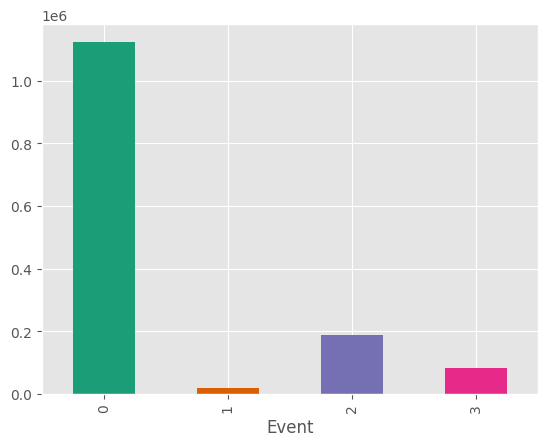

In [15]:
#Uneven distribution of labels
tdcsfog_event_counts = train_tdcsfog.Event.value_counts().sort_index()
cmap = plt.get_cmap('Dark2')
tdcsfog_event_counts.plot(kind='bar', color=cmap(range(len(tdcsfog_event_counts))))
plt.show()

In [16]:
#Distribution of Events vs. No Event
count = np.bincount(train_tdcsfog.Event)
pos = sum([count[1], count[2], count[3]])
neg = count[0]
total = pos+neg
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1412867
    Positive: 289283 (20.47% of total)



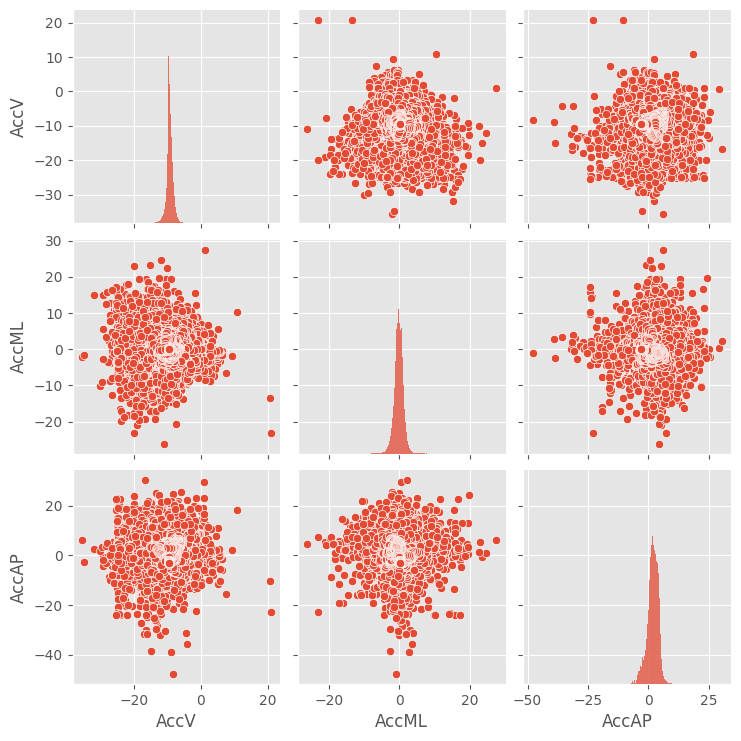

In [22]:
sns.pairplot(train_tdcsfog[['AccV', 'AccML', 'AccAP']])

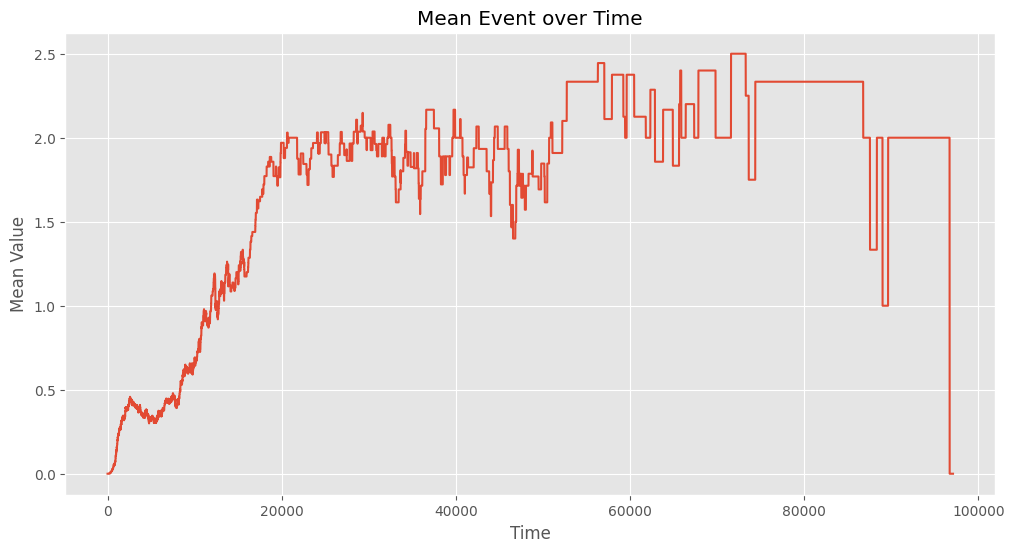

In [26]:
plt.figure(figsize=(12, 6))

events_over_time = train_tdcsfog.groupby('Time')['Event'].mean().reset_index()
# Plot the mean 'Event' values over time.
plt.plot(events_over_time['Time'],events_over_time['Event'], label='Event')

plt.xlabel('Time')

# Set the y-label of the plot.
plt.ylabel('Mean Value')

# Set the title of the plot.
plt.title('Mean Event over Time')

# Display the plot.
plt.show()


### DEFOG

##### DEFOG - Valid Records

In [20]:
#Only interested in the valid annotations from professionals in the defog dataset
defog_valid = train_defog[(train_defog['Task'] == True) & (train_defog['Valid'] == True)]
defog_valid.drop(columns=['Task', 'Valid'], inplace=True)

In [21]:
defog_valid = adjust_time(defog_valid)

##### Event Encoding 

In [22]:
defog_valid['Event'] = defog_valid.apply(lambda x: 1 if x['StartHesitation'] else 2 if x['Turn'] else 3 if x['Walking'] else 0, axis=1)
defog_valid.drop(columns=['StartHesitation', 'Turn', 'Walking'], inplace=True)
defog_valid.head()

,Time,AccV,AccML,AccAP,Id,Event
1000,0,-0.970018,0.061626,-0.265625,02ea782681,0
1001,1,-0.984375,0.044497,-0.265625,02ea782681,0
1002,2,-0.984375,0.029016,-0.265625,02ea782681,0
1003,3,-0.984375,0.015625,-0.265625,02ea782681,0
1004,4,-0.984670,0.015330,-0.265625,02ea782681,0


##### Accelerometer Adjustment

In [23]:
#Because the positional values in tdcsfog are in m/s^2 and defog are in g
#Tranform the data to represent this
defog_valid[['AccV', 'AccML', 'AccAP']] = defog_valid[['AccV', 'AccML', 'AccAP']].apply(lambda x: x*9.80665)
defog_valid.head()

,Time,AccV,AccML,AccAP,Id,Event
1000,0,-9.512631,0.604345,-2.604891,02ea782681,0
1001,1,-9.653421,0.436363,-2.604891,02ea782681,0
1002,2,-9.653421,0.284552,-2.604891,02ea782681,0
1003,3,-9.653421,0.153229,-2.604891,02ea782681,0
1004,4,-9.656311,0.150339,-2.604891,02ea782681,0


### Combined Data

In [24]:
train = pd.concat([train_tdcsfog, defog_valid], axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11153202 entries, 0 to 119031
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    int64  
 1   AccV    float64
 2   AccML   float64
 3   AccAP   float64
 4   Id      object 
 5   Event   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 595.6+ MB


## metadata

In [63]:
#Identifies each series in the tdcsfog dataset by a unique Subject, Visit, Test, Mediation condition
#Visit: Lab visits consist of a baseline assessment, two post-treatment assessments for different treatment stages,
#and one follow-up assessment
#Test: Which of three test types was performed, with 3 the most challenging*
#Medication: Subjects may have been off or on anti-parkinsonian medication during the recording
tdcsfog_metadata.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2,on
1,009ee11563,f62eec,4,2,on
2,011322847a,231c3b,2,2,on
3,01d0fe7266,231c3b,2,1,off
4,024418ba39,fa8764,19,3,on


In [64]:
tdcsfog_metadata.shape

(833, 5)

In [65]:
#Identifies each series in the defog dataset by a unique Subject, Visit, Medication condition.
defog_metadata.head()

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on


In [66]:
defog_metadata.shape

(137, 4)

In [25]:
meta_combined = pd.concat([tdcsfog_metadata, defog_metadata], axis=0)
meta_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 0 to 136
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          970 non-null    object 
 1   Subject     970 non-null    object 
 2   Visit       970 non-null    int64  
 3   Test        833 non-null    float64
 4   Medication  970 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 45.5+ KB


In [26]:
meta_combined['Test'] = meta_combined.Test.fillna(0)
meta_combined.isna().sum()

Id            0
Subject       0
Visit         0
Test          0
Medication    0
dtype: int64

In [27]:
#Label Encoding Medication
le = LabelEncoder()
meta_combined['Medication'] = le.fit_transform(meta_combined['Medication'])
meta_combined.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2.0,1
1,009ee11563,f62eec,4,2.0,1
2,011322847a,231c3b,2,2.0,1
3,01d0fe7266,231c3b,2,1.0,0
4,024418ba39,fa8764,19,3.0,1


In [28]:
meta_combined.nunique()

Id            970
Subject       107
Visit           8
Test            4
Medication      2
dtype: int64

#### Subjects

In [43]:
#Metadata for each Subject in the study, including their Age and Sex as well as:
#Visit: Only available for subjects in the daily and defog datasets.
#YearsSinceDx: Years since Parkinson's diagnosis
#UPDRSIIIOn/UPDRSIIIOff: Unified Parkinson's Disease Rating Scale score during on/off medication respectively
#NFOGQ: Self-report FoG questionnaire score
subjects.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,M,27.0,43.0,49.0,24
1,00f674,1.0,63,M,27.0,31.0,30.0,26
2,02bc69,NaN,69,M,4.0,21.0,NaN,22
3,040587,2.0,75,M,26.0,52.0,69.0,21
4,040587,1.0,75,M,26.0,47.0,75.0,24


In [44]:
subjects.shape

(173, 8)

In [29]:
#Encode the Sex
subjects['Sex'] = le.fit_transform(subjects.Sex)
subjects.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,1,27.0,43.0,49.0,24
1,00f674,1.0,63,1,27.0,31.0,30.0,26
2,02bc69,NaN,69,1,4.0,21.0,NaN,22
3,040587,2.0,75,1,26.0,52.0,69.0,21
4,040587,1.0,75,1,26.0,47.0,75.0,24


In [30]:
subject_subset = subjects[['Subject', 'Age', 'Sex', 'YearsSinceDx']].drop_duplicates()
subject_subset.head()

,Subject,Age,Sex,YearsSinceDx
0,00f674,63,1,27.0
2,02bc69,69,1,4.0
3,040587,75,1,26.0
5,056372,69,1,13.0
6,07285e,58,1,1.0


In [31]:
subject_subset.nunique()

Subject         136
Age              34
Sex               2
YearsSinceDx     30
dtype: int64

In [32]:
subject_metadata = meta_combined.merge(subject_subset, how='inner')
subject_metadata

,Id,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx
0,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
1,15671a03ca,4dc2f8,2,2.0,0,68,0,9.0
2,2ca9bd3533,4dc2f8,2,3.0,1,68,0,9.0
3,3c535f4851,4dc2f8,4,1.0,1,68,0,9.0
4,5a321dde31,4dc2f8,2,3.0,0,68,0,9.0
...,...,...,...,...,...,...,...,...
969,c7f06a72e7,5d9cae,2,0.0,1,72,1,14.0
970,daa4d27db4,5d9cae,1,0.0,0,72,0,14.0
971,daa4d27db4,5d9cae,1,0.0,0,72,1,14.0
972,f9efef91fb,5d9cae,2,0.0,0,72,0,14.0


#### Events/Daily/Tasks - Didn't use

In [173]:
#Metadata for each FoG event in all data series. The event times agree with the labels in the data series
#Id: The data series the event occured in
#Init: Time(s) the event began
#Completion: Time(s) the event ended
#Type: Whether StartHesitation, Turn, or Walking
#Kinetic: Whether the event was kinetic (1) and involved movement, or akinetic(0) and static
events.head()

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61312,14.7731,Turn,1.0
1,009ee11563,11.38470,41.1847,Turn,1.0
2,009ee11563,54.66470,58.7847,Turn,1.0
3,011322847a,28.09660,30.2966,Turn,1.0
4,01d0fe7266,30.31840,31.8784,Turn,1.0


In [174]:
events.shape

(3544, 5)

In [175]:
events.describe()

,Init,Completion,Kinetic
count,3544.000000,3544.000000,2502.000000
mean,956.298418,964.489046,0.817746
std,946.357201,943.968560,0.386131
min,-30.669000,-29.719000,0.000000
25%,39.518175,48.610800,1.000000
50%,768.656500,774.261000,1.000000
75%,1570.300000,1576.697250,1.000000
max,4381.217000,4392.745000,1.000000


In [176]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544 entries, 0 to 3543
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          3544 non-null   object 
 1   Init        3544 non-null   float64
 2   Completion  3544 non-null   float64
 3   Type        2502 non-null   object 
 4   Kinetic     2502 non-null   float64
dtypes: float64(3), object(2)
memory usage: 138.6+ KB


In [177]:
events['Type'] = events.Type.fillna('Turn')
events['Kinetic'] = events.Kinetic.fillna(0)
events.isna().sum()

Id            0
Init          0
Completion    0
Type          0
Kinetic       0
dtype: int64

##### Tasks

In [178]:
#Task metadata for series in the defog dataset. (Not relevant for the series in the tdcsfog or daily datasets.)
#Id: The data series where the task was measured.
#Begin: Time(s) the task begain
#End: Time(s) the task ended
#Task: One of seven tasks types in the DeFOG protocol
tasks.head()

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2
2,02ab235146,505.88,522.40,4MW
3,02ab235146,577.96,594.64,4MW-C
4,02ab235146,701.32,715.28,MB1


In [47]:
tasks.Task.unique()

array(['Rest1', 'Rest2', '4MW', '4MW-C', 'MB1', 'MB2a', 'MB2b', 'MB3-R',
       'MB3-L', 'MB4', 'MB5', 'MB6-R', 'MB6-L', 'MB7', 'MB8', 'MB9',
       'MB10', 'MB11', 'MB12', 'MB13', 'TUG-ST', 'TUG-DT', 'TUG-C',
       'Turning-ST', 'Turning-DT', 'Turning-C', 'Hotspot1', 'Hotspot1-C',
       'Hotspot2', 'Hotspot2-C', 'MB6'], dtype=object)

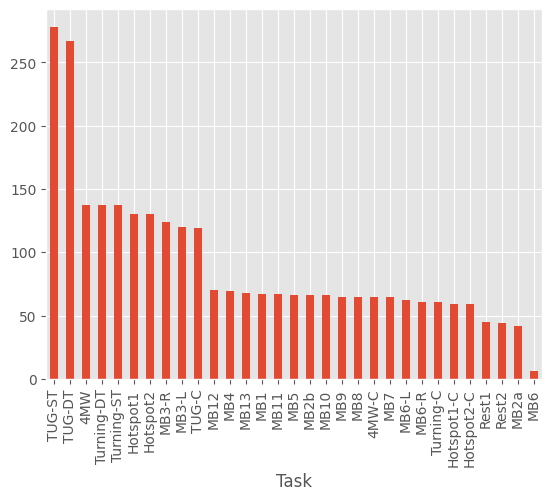

In [48]:
tasks_counts = tasks.Task.value_counts()
ax = tasks_counts.plot(kind='bar')
plt.show()

##### Daily

In [179]:
#Each series in the daily dataset is identified by the Subject id.
#This file also contains the time of day the recording began.
daily_metadata.head()

,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,fba3a3,1,10:19
1,07a96f89ec,7da72f,1,07:30
2,0d1bc672a8,056372,2,08:30
3,0e333c9833,b4bd22,1,11:30
4,164adaed7b,9f72eb,1,13:00


In [180]:
daily_metadata.shape

(65, 4)

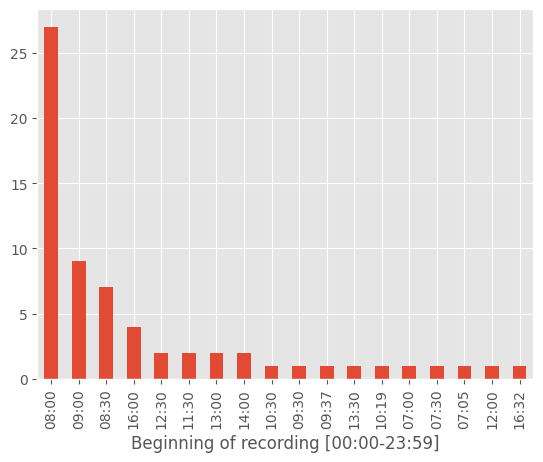

In [181]:
daily_bar_count = daily_metadata['Beginning of recording [00:00-23:59]'].value_counts()
ax = daily_bar_count.plot(x=daily_bar_count.index, y=daily_bar_count.values, kind='bar')
plt.show()

In [42]:
train_combined.head()

,Time,AccV,AccML,AccAP,Id,Event
0,0,-9.533939,0.566322,-1.413525,003f117e14,0
1,1,-9.536140,0.564137,-1.440621,003f117e14,0
2,2,-9.529346,0.561765,-1.429332,003f117e14,0
3,3,-9.531239,0.564227,-1.415490,003f117e14,0
4,4,-9.540825,0.561854,-1.429471,003f117e14,0


In [43]:
train_combined.info()
print(f'\nMerged Training Data Shape: {train_combined.shape}')

<class 'pandas.core.frame.DataFrame'>
Index: 11153202 entries, 0 to 119031
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    int32  
 1   AccV    float32
 2   AccML   float32
 3   AccAP   float32
 4   Id      object 
 5   Event   int64  
dtypes: float32(3), int32(1), int64(1), object(1)
memory usage: 425.5+ MB

Merged Training Data Shape: (11153202, 6)


In [44]:
train_combined.describe()

,Time,AccV,AccML,AccAP,Event
count,1.115320e+07,1.115320e+07,1.115320e+07,1.115320e+07,1.115320e+07
mean,1.648273e+04,-9.256983e+00,-1.318629e-01,3.328988e-01,5.160473e-01
std,2.078726e+04,1.071841e+00,1.312196e+00,3.029485e+00,9.059920e-01
min,0.000000e+00,-5.910231e+01,-2.616440e+01,-5.021396e+01,0.000000e+00
25%,3.019000e+03,-9.725100e+00,-9.021833e-01,-2.131031e+00,0.000000e+00
50%,7.050000e+03,-9.312897e+00,-1.159167e-01,6.957161e-01,0.000000e+00
75%,2.367400e+04,-8.737032e+00,6.852229e-01,2.730200e+00,1.000000e+00
max,1.426090e+05,4.373656e+01,4.438081e+01,4.304758e+01,3.000000e+00


In [16]:
test_df = pd.read_csv('test.csv')

In [17]:
sub_scaler = StandardScaler()
train[['AccV', 'AccML', 'AccAP']] = sub_scaler.fit_transform(train[['AccV', 'AccML', 'AccAP']])
test_df[['AccV', 'AccML', 'AccAP']] = sub_scaler.transform(test_df[['AccV', 'AccML', 'AccAP']])
train.describe()

,Time,AccV,AccML,AccAP,Event
count,4.507173e+06,4.507173e+06,4.507173e+06,4.507173e+06,4.507173e+06
mean,7.188731e+03,1.295949e-08,1.164593e-08,6.380888e-08,5.146528e-01
std,9.548080e+03,1.000000e+00,1.000000e+00,1.000000e+00,9.446234e-01
min,0.000000e+00,-3.832083e+01,-1.659063e+01,-1.551652e+01,0.000000e+00
25%,1.220000e+03,-4.113570e-01,-5.847536e-01,-8.192585e-01,0.000000e+00
50%,2.876000e+03,2.079658e-03,1.696730e-02,1.058360e-01,0.000000e+00
75%,9.944000e+03,4.939507e-01,6.309091e-01,7.862843e-01,0.000000e+00
max,6.597500e+04,4.395410e+01,1.771113e+01,1.049589e+01,3.000000e+00


In [5]:
test_df.describe()

,Time,AccV,AccML,AccAP
count,286370.000000,286370.000000,286370.000000,286370.000000
mean,138579.048256,-1.075881,-0.026671,0.022435
std,82539.657212,1.058454,0.225871,0.504250
min,0.000000,-23.796051,-9.097370,-7.353417
25%,66910.250000,-0.982743,-0.206359,-0.218339
50%,138502.500000,-0.955240,0.007004,-0.083812
75%,210094.750000,-0.900158,0.072389,0.270503
max,281687.000000,0.536504,5.996705,10.281080


In [18]:
#test_df.to_csv('test_subset.csv', index=False)
#train.to_csv('subset.csv', index=False)

### Downsample

In [33]:
#11,153,202 entries
train

,Time,AccV,AccML,AccAP,Id,Event
0,0,-9.533939,0.566322,-1.413525,003f117e14,0
1,1,-9.536140,0.564137,-1.440621,003f117e14,0
2,2,-9.529345,0.561765,-1.429332,003f117e14,0
3,3,-9.531239,0.564227,-1.415490,003f117e14,0
4,4,-9.540825,0.561854,-1.429471,003f117e14,0
...,...,...,...,...,...,...
119027,35935,-9.426314,1.396738,-2.840550,f9fc61ce85,0
119028,35936,-9.417744,1.400740,-2.848892,f9fc61ce85,0
119029,35937,-9.394363,1.426807,-2.843998,f9fc61ce85,0
119030,35938,-9.420424,1.430195,-2.858901,f9fc61ce85,0


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11153202 entries, 0 to 119031
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    int32  
 1   AccV    float32
 2   AccML   float32
 3   AccAP   float32
 4   Id      object 
 5   Event   int64  
dtypes: float32(3), int32(1), int64(1), object(1)
memory usage: 425.5+ MB


In [34]:
train.Time = pd.to_timedelta(train.Time, 's', errors='coerce')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11153202 entries, 0 to 119031
Data columns (total 6 columns):
 #   Column  Dtype          
---  ------  -----          
 0   Time    timedelta64[ns]
 1   AccV    float64        
 2   AccML   float64        
 3   AccAP   float64        
 4   Id      object         
 5   Event   int64          
dtypes: float64(3), int64(1), object(1), timedelta64[ns](1)
memory usage: 595.6+ MB


In [35]:
positional_data = train[['Id', 'Time', 'AccV', 'AccML', 'AccAP']]
subject_data = train[['Id', 'Time', 'Event']]
subject_data.set_index(['Id', 'Time'], inplace=True)
positional_data.head()

,Id,Time,AccV,AccML,AccAP
0,003f117e14,0 days 00:00:00,-9.533939,0.566322,-1.413525
1,003f117e14,0 days 00:00:01,-9.536140,0.564137,-1.440621
2,003f117e14,0 days 00:00:02,-9.529345,0.561765,-1.429332
3,003f117e14,0 days 00:00:03,-9.531239,0.564227,-1.415490
4,003f117e14,0 days 00:00:04,-9.540825,0.561854,-1.429471


In [52]:
subject_data.head()

Event
Id         Time                  
003f117e14 0 days 00:00:00      0
           0 days 00:00:01      0
           0 days 00:00:02      0
           0 days 00:00:03      0
           0 days 00:00:04      0

In [36]:
positional_resample = positional_data.groupby(['Id']).resample('30s', on='Time').mean()
positional_resample.head()

AccV     AccML     AccAP
Id         Time                                         
003f117e14 0 days 00:00:00 -9.532633  0.556340 -1.418248
           0 days 00:00:30 -9.535179  0.554593 -1.398022
           0 days 00:01:00 -9.534571  0.552661 -1.402051
           0 days 00:01:30 -9.530654  0.550440 -1.443643
           0 days 00:02:00 -9.523916  0.550992 -1.481100

In [54]:
positional_resample.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 372205 entries, ('003f117e14', Timedelta('0 days 00:00:00')) to ('ffda8fadfd', Timedelta('0 days 01:10:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AccV    372205 non-null  float32
 1   AccML   372205 non-null  float32
 2   AccAP   372205 non-null  float32
dtypes: float32(3)
memory usage: 5.9+ MB


In [46]:
downsample_df = positional_resample.join(subject_data, how='left').reset_index()
downsample_df.head()

,Id,Time,AccV,AccML,AccAP,Event
0,003f117e14,0 days 00:00:00,-9.532633,0.556340,-1.418248,0
1,003f117e14,0 days 00:00:30,-9.535179,0.554593,-1.398022,0
2,003f117e14,0 days 00:01:00,-9.534571,0.552661,-1.402051,0
3,003f117e14,0 days 00:01:30,-9.530654,0.550440,-1.443643,0
4,003f117e14,0 days 00:02:00,-9.523916,0.550992,-1.481100,0


In [47]:
downsample_df = downsample_df.merge(subject_metadata, on='Id', how='left')
downsample_df = adjust_time(downsample_df)
downsample_df.head()

,Id,Time,AccV,AccML,AccAP,Event,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx
0,003f117e14,0,-9.532633,0.556340,-1.418248,0,4dc2f8,3,2.0,1,68,0,9.0
1,003f117e14,1,-9.535179,0.554593,-1.398022,0,4dc2f8,3,2.0,1,68,0,9.0
2,003f117e14,2,-9.534571,0.552661,-1.402051,0,4dc2f8,3,2.0,1,68,0,9.0
3,003f117e14,3,-9.530654,0.550440,-1.443643,0,4dc2f8,3,2.0,1,68,0,9.0
4,003f117e14,4,-9.523916,0.550992,-1.481100,0,4dc2f8,3,2.0,1,68,0,9.0


In [48]:
#Readjust Event column
event = downsample_df.Event
downsample_df.drop(columns='Event', inplace=True)
downsample_df['Event'] = event
downsample_df.head()

,Id,Time,AccV,AccML,AccAP,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx,Event
0,003f117e14,0,-9.532633,0.556340,-1.418248,4dc2f8,3,2.0,1,68,0,9.0,0
1,003f117e14,1,-9.535179,0.554593,-1.398022,4dc2f8,3,2.0,1,68,0,9.0,0
2,003f117e14,2,-9.534571,0.552661,-1.402051,4dc2f8,3,2.0,1,68,0,9.0,0
3,003f117e14,3,-9.530654,0.550440,-1.443643,4dc2f8,3,2.0,1,68,0,9.0,0
4,003f117e14,4,-9.523916,0.550992,-1.481100,4dc2f8,3,2.0,1,68,0,9.0,0


In [52]:
#Add Metadata to Test dataset before scaling
test_df = test_df.merge(subject_metadata, on='Id', how='left')
test_df

,Time,AccV,AccML,AccAP,Id,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx
0,0,-9.533939,0.566322,-1.413525,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
1,1,-9.536140,0.564137,-1.440621,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
2,2,-9.529345,0.561765,-1.429332,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
3,3,-9.531239,0.564227,-1.415490,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
4,4,-9.540825,0.561854,-1.429471,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
286365,281683,-8.819108,-2.281697,3.816226,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286366,281684,-8.845331,-2.285448,3.825707,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286367,281685,-8.842554,-2.274049,3.843183,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286368,281686,-8.821827,-2.279355,3.835436,02ab235146,e1f62e,2,0.0,1,79,0,8.0


#### Standardize

In [53]:
down_scaler = StandardScaler()

downsample_df[['AccV', 'AccML', 'AccAP', 'Visit', 'Test', 'Medication', 'Age', 'Sex', 'YearsSinceDx']] = down_scaler.fit_transform(downsample_df[['AccV', 'AccML', 'AccAP', 'Visit', 'Test', 'Medication', 'Age', 'Sex', 'YearsSinceDx']])

test_df[['AccV', 'AccML', 'AccAP', 'Visit', 'Test', 'Medication', 'Age', 'Sex', 'YearsSinceDx']] = down_scaler.transform(test_df[['AccV', 'AccML', 'AccAP', 'Visit', 'Test', 'Medication', 'Age', 'Sex', 'YearsSinceDx']])

In [54]:
downsample_df.describe()

,Time,AccV,AccML,AccAP,Visit,Test,Medication,Age,Sex,YearsSinceDx,Event
count,376345.000000,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,3.763450e+05,376345.000000
mean,560.579540,1.643021e-15,2.416651e-18,-3.624977e-17,-1.014994e-16,6.041629e-17,-4.833303e-18,7.370787e-17,-1.643323e-16,1.377491e-16,0.512471
std,699.492492,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.903896
min,0.000000,-7.651272e+00,-6.550717e+00,-3.483640e+00,-6.736359e-01,-1.086590e+00,-1.154029e+00,-5.138474e+00,-1.719166e+00,-1.459456e+00,0.000000
25%,101.000000,-6.161664e-01,-6.259218e-01,-8.321524e-01,-5.098578e-01,-1.086590e+00,-1.154029e+00,-4.877341e-01,-1.719166e+00,-8.211166e-01,0.000000
50%,240.000000,-1.492870e-01,4.456225e-03,1.452204e-01,-5.098578e-01,-2.581620e-01,8.665296e-01,1.407443e-01,5.816775e-01,-1.827774e-01,0.000000
75%,816.000000,5.374631e-01,6.811716e-01,8.109457e-01,-1.823016e-01,5.702656e-01,8.665296e-01,6.435270e-01,5.816775e-01,6.151467e-01,1.000000
max,4753.000000,9.523327e+00,4.340472e+00,2.969281e+00,2.438148e+00,1.398693e+00,8.665296e-01,3.157441e+00,5.816775e-01,3.168504e+00,3.000000


In [55]:
test_df.describe()

,Time,AccV,AccML,AccAP,Visit,Test,Medication,Age,Sex,YearsSinceDx
count,286370.000000,286370.000000,286370.000000,286370.000000,286370.000000,286370.000000,2.863700e+05,286370.000000,2.863700e+05,286370.000000
mean,138579.048256,0.039125,-0.229145,-0.150922,-0.507180,-1.059501,8.665296e-01,1.249400,-1.719166e+00,-0.339753
std,82539.657212,1.105154,1.410655,0.908554,0.020770,0.210115,5.551125e-16,0.175342,2.220450e-16,0.020238
min,0.000000,-22.223430,-10.299175,-3.729912,-0.509858,-1.086590,8.665296e-01,-0.110647,-1.719166e+00,-0.342362
25%,66910.250000,-0.564220,-1.842645,-0.826728,-0.509858,-1.086590,8.665296e-01,1.272005,-1.719166e+00,-0.342362
50%,138502.500000,-0.137527,0.200865,-0.383423,-0.509858,-1.086590,8.665296e-01,1.272005,-1.719166e+00,-0.342362
75%,210094.750000,0.676674,0.813054,0.780453,-0.509858,-1.086590,8.665296e-01,1.272005,-1.719166e+00,-0.342362
max,281687.000000,22.197082,7.248304,3.382995,-0.346080,0.570266,8.665296e-01,1.272005,-1.719166e+00,-0.182777


In [57]:
test_df

,Time,AccV,AccML,AccAP,Id,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx
0,0,-0.420678,0.690095,-0.584365,003f117e14,4dc2f8,-0.346080,0.570266,0.86653,-0.110647,-1.719166,-0.182777
1,1,-0.424043,0.687950,-0.593557,003f117e14,4dc2f8,-0.346080,0.570266,0.86653,-0.110647,-1.719166,-0.182777
2,2,-0.413655,0.685621,-0.589727,003f117e14,4dc2f8,-0.346080,0.570266,0.86653,-0.110647,-1.719166,-0.182777
3,3,-0.416550,0.688039,-0.585032,003f117e14,4dc2f8,-0.346080,0.570266,0.86653,-0.110647,-1.719166,-0.182777
4,4,-0.431204,0.685708,-0.589775,003f117e14,4dc2f8,-0.346080,0.570266,0.86653,-0.110647,-1.719166,-0.182777
...,...,...,...,...,...,...,...,...,...,...,...,...
286365,281683,0.672098,-2.105837,1.189812,02ab235146,e1f62e,-0.509858,-1.086590,0.86653,1.272005,-1.719166,-0.342362
286366,281684,0.632010,-2.109519,1.193029,02ab235146,e1f62e,-0.509858,-1.086590,0.86653,1.272005,-1.719166,-0.342362
286367,281685,0.636255,-2.098329,1.198957,02ab235146,e1f62e,-0.509858,-1.086590,0.86653,1.272005,-1.719166,-0.342362
286368,281686,0.667941,-2.103537,1.196329,02ab235146,e1f62e,-0.509858,-1.086590,0.86653,1.272005,-1.719166,-0.342362


In [58]:
train = downsample_df.drop(columns=['Id', 'Subject'])
test = test_df.drop(columns='Subject')

In [59]:
#train.to_csv('train.csv', index=False)
#test.to_csv('test.csv', index=False)

In [39]:
test_sub = pd.read_csv('test_subset.csv')
test_sub

,Time,AccV,AccML,AccAP,Id
0,0,-0.236636,0.500452,-0.519794,003f117e14
1,1,-0.238462,0.498884,-0.528549,003f117e14
2,2,-0.232826,0.497181,-0.524901,003f117e14
3,3,-0.234396,0.498949,-0.520429,003f117e14
4,4,-0.242348,0.497245,-0.524946,003f117e14
...,...,...,...,...,...
286365,281683,6.926261,-0.073130,0.062637,02ab235146
286366,281684,6.924043,-0.073405,0.062949,02ab235146
286367,281685,6.924278,-0.072570,0.063525,02ab235146
286368,281686,6.926031,-0.072959,0.063269,02ab235146


In [41]:
test_sub = test_sub.merge(subject_metadata, on='Id', how='left')
test_sub

,Time,AccV,AccML,AccAP,Id,Subject,Visit,Test,Medication,Age,Sex,YearsSinceDx
0,0,-0.236636,0.500452,-0.519794,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
1,1,-0.238462,0.498884,-0.528549,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
2,2,-0.232826,0.497181,-0.524901,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
3,3,-0.234396,0.498949,-0.520429,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
4,4,-0.242348,0.497245,-0.524946,003f117e14,4dc2f8,3,2.0,1,68,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
286365,281683,6.926261,-0.073130,0.062637,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286366,281684,6.924043,-0.073405,0.062949,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286367,281685,6.924278,-0.072570,0.063525,02ab235146,e1f62e,2,0.0,1,79,0,8.0
286368,281686,6.926031,-0.072959,0.063269,02ab235146,e1f62e,2,0.0,1,79,0,8.0


In [ ]:
#test.to_csv('test_subset.csv', index=False)